https://marinecadastre.gov/data/

[Office for Coastal Management, 2023: Nationwide Automatic Identification System 2022, https://www.fisheries.noaa.gov/inport/item/67336](https://www.fisheries.noaa.gov/inport/item/67336)

https://coast.noaa.gov/data/marinecadastre/ais/data-dictionary.pdf

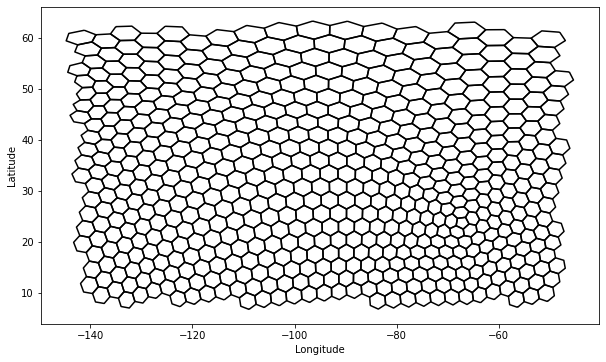

In [0]:
# Import required libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from h3 import h3

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 2

# Generate a list of hexagon centers that fall within the lat/lon bounds
hex_centers = []
lat_values = np.arange(min_lat, max_lat, 0.1)
lon_values = np.arange(min_lon, max_lon, 0.1)
for lat in lat_values:
    for lon in lon_values:
        hex_centers.append(h3.geo_to_h3(lat, lon, resolution))

# Remove duplicate hexagon centers
hex_centers = list(set(hex_centers))

# Generate the polygons for each hexagon
hex_polygons = []
for hex_center in hex_centers:
    # Get the geo coordinates of the hexagon boundaries
    hex_boundary = h3.h3_to_geo_boundary(hex_center)

    # Create a shapely Polygon from these coordinates, swap lat-lon to lon-lat
    hex_polygons.append(Polygon([(lon, lat) for lat, lon in hex_boundary]))

# Create a Geopandas GeoDataFrame from the hexagon polygons
gdf = gpd.GeoDataFrame(geometry=hex_polygons)

# Plot the hexagon grid
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


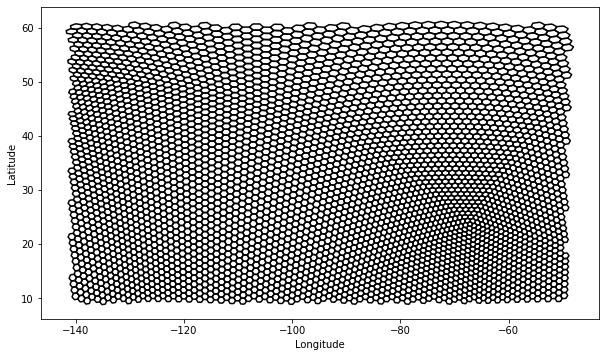

In [0]:
# Import required libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from h3 import h3

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 3

# Generate a list of hexagon centers that fall within the lat/lon bounds
hex_centers = []
lat_values = np.arange(min_lat, max_lat, 0.1)
lon_values = np.arange(min_lon, max_lon, 0.1)
for lat in lat_values:
    for lon in lon_values:
        hex_centers.append(h3.geo_to_h3(lat, lon, resolution))

# Remove duplicate hexagon centers
hex_centers = list(set(hex_centers))

# Generate the polygons for each hexagon
hex_polygons = []
for hex_center in hex_centers:
    # Get the geo coordinates of the hexagon boundaries
    hex_boundary = h3.h3_to_geo_boundary(hex_center)

    # Create a shapely Polygon from these coordinates, swap lat-lon to lon-lat
    hex_polygons.append(Polygon([(lon, lat) for lat, lon in hex_boundary]))

# Create a Geopandas GeoDataFrame from the hexagon polygons
gdf = gpd.GeoDataFrame(geometry=hex_polygons)

# Plot the hexagon grid
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [0]:
spark.read.table("ais.june").printSchema()

root
 |-- MMSI: string (nullable = true)
 |-- BaseDateTime: timestamp (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- SOG: double (nullable = true)
 |-- COG: double (nullable = true)
 |-- Heading: double (nullable = true)
 |-- VesselName: string (nullable = true)
 |-- IMO: string (nullable = true)
 |-- CallSign: string (nullable = true)
 |-- VesselType: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Length: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Draft: double (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- TranscieverClass: string (nullable = true)
 |-- filename: string (nullable = true)



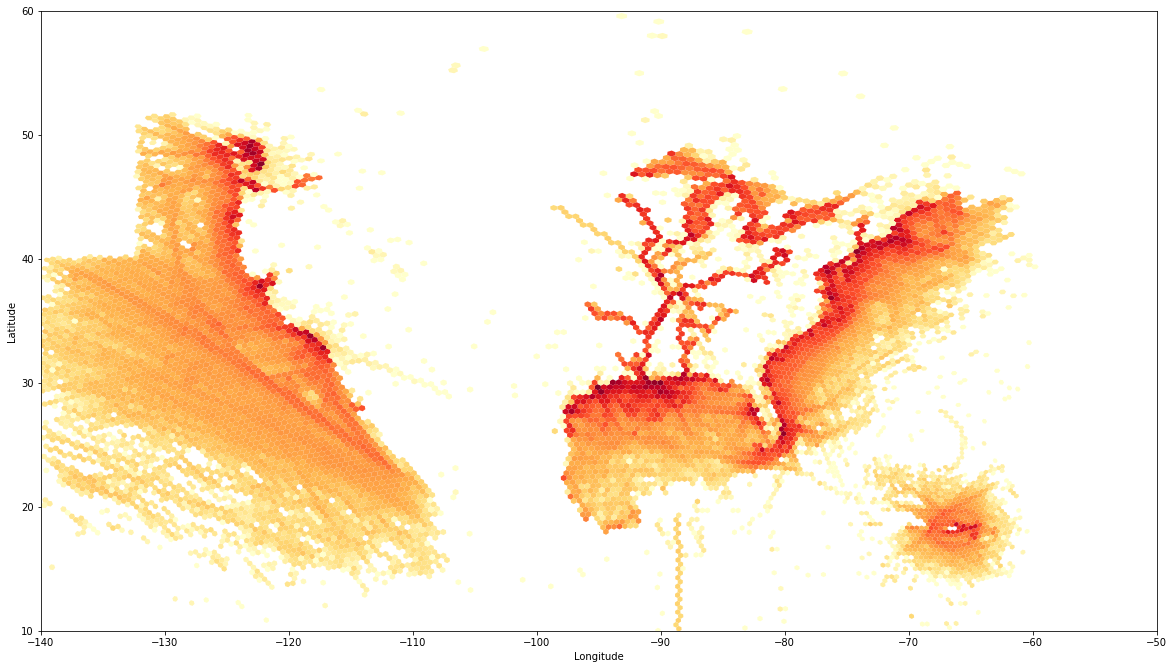

In [0]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 4

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june")

# Add a 'resolution' column
df_ais_june = df_ais_june.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each location using the UDF
df_ais_june = df_ais_june.withColumn('hex_id', h3_pyspark.geo_to_h3(df_ais_june['LAT'], df_ais_june['LON'], df_ais_june['resolution']))

# Count the occurrences of each hex_id to get the density
df_density = df_ais_june.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

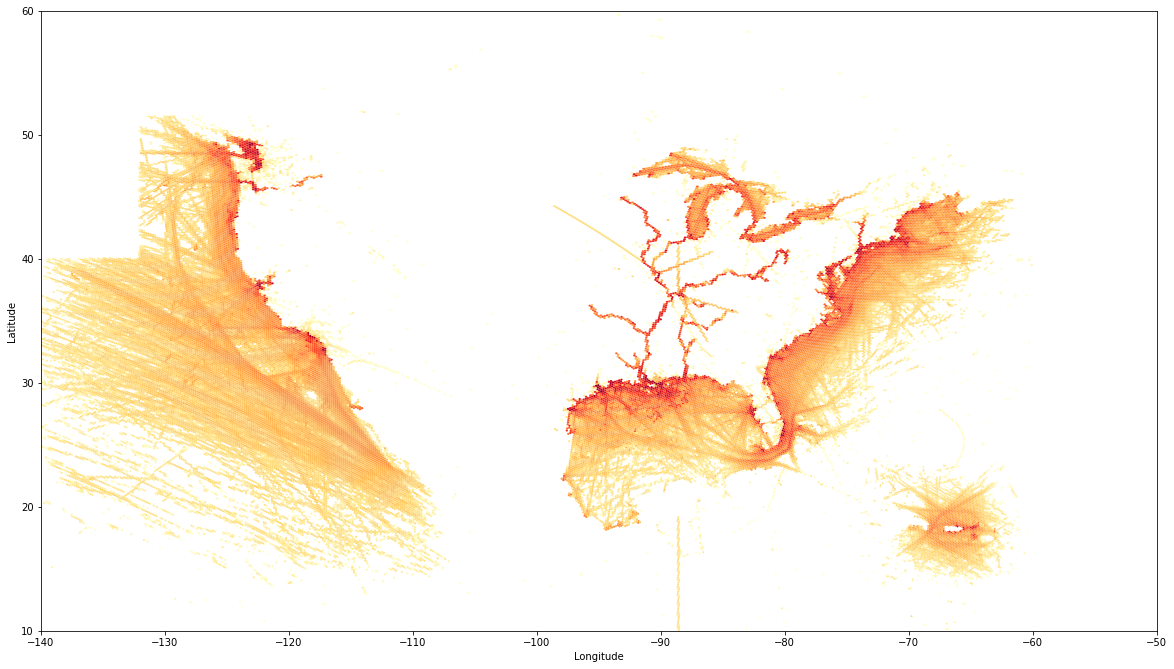

In [0]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 5

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june")

# Add a 'resolution' column
df_ais_june = df_ais_june.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each location using the UDF
df_ais_june = df_ais_june.withColumn('hex_id', h3_pyspark.geo_to_h3(df_ais_june['LAT'], df_ais_june['LON'], df_ais_june['resolution']))

# Count the occurrences of each hex_id to get the density
df_density = df_ais_june.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

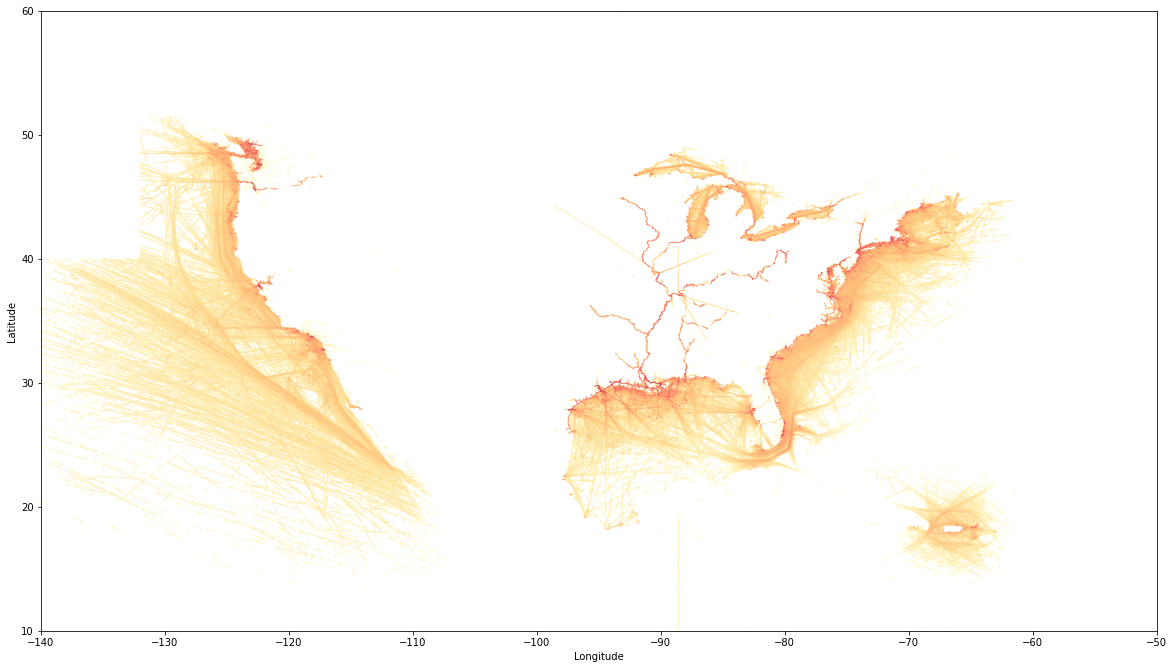

In [0]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 6

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june")

# Add a 'resolution' column
df_ais_june = df_ais_june.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each location using the UDF
df_ais_june = df_ais_june.withColumn('hex_id', h3_pyspark.geo_to_h3(df_ais_june['LAT'], df_ais_june['LON'], df_ais_june['resolution']))

# Count the occurrences of each hex_id to get the density
df_density = df_ais_june.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

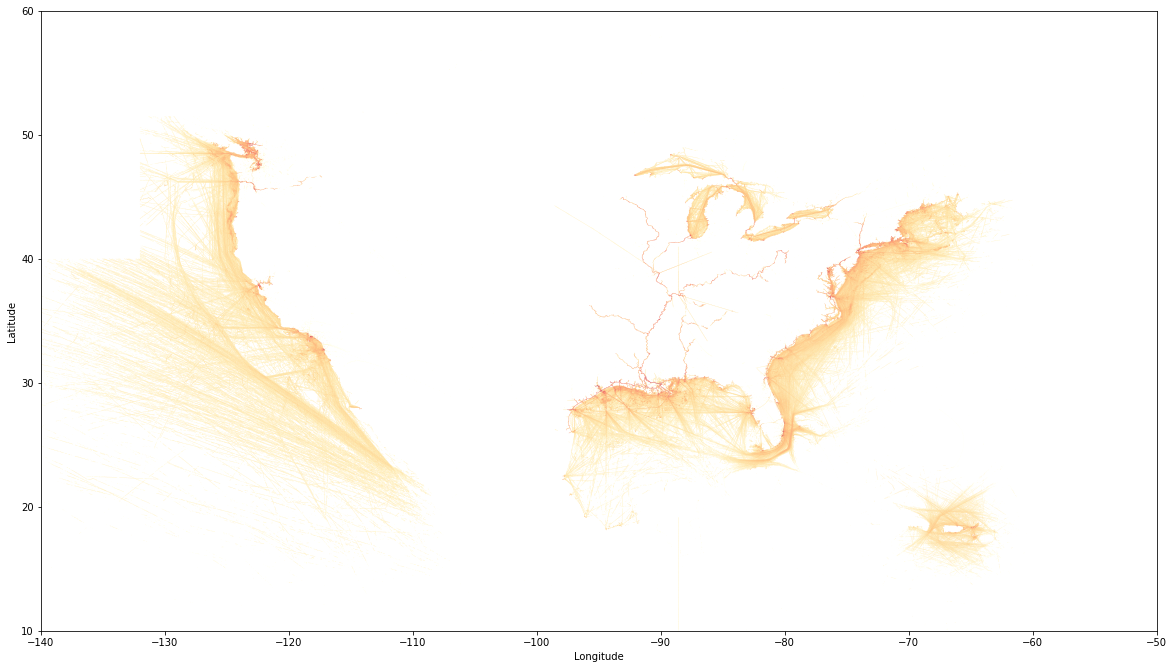

In [0]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 7

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june")

# Add a 'resolution' column
df_ais_june = df_ais_june.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each location using the UDF
df_ais_june = df_ais_june.withColumn('hex_id', h3_pyspark.geo_to_h3(df_ais_june['LAT'], df_ais_june['LON'], df_ais_june['resolution']))

# Count the occurrences of each hex_id to get the density
df_density = df_ais_june.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

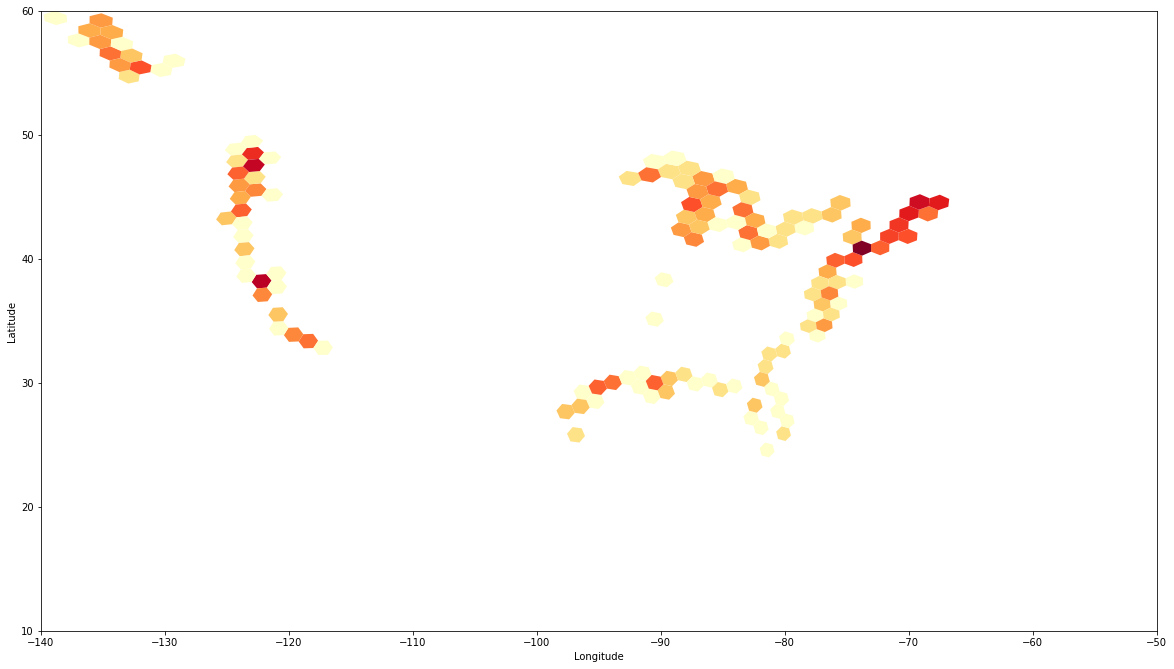

In [0]:
# Import required libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 3

# Read the spark dataframe for ports
df_ports = spark.read.table("ais.UpdatedPub150_US")

# Add a 'resolution' column
df_ports = df_ports.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each port location
df_ports = df_ports.withColumn('hex_id', h3_pyspark.geo_to_h3('Latitude', 'Longitude', 'resolution'))

# Count the occurrences of each hex_id to get the density of ports
df_density = df_ports.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map with the YlOrRd colormap
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()